In [4]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4666 sha256=a4b5d9d0c91c8186eb2f2d603c1c3e50d4610a2896c98834348eb28ab2e676e3
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras-layer-normalization


In [8]:
from keras.datasets import mnist
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Define input image dimensions
# Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

##########################################################################
# Given input of noise (latent) vector, the Generator produces an image.


def build_generator():

    noise_shape = (100,)  # 1D array of size 100 (latent vector / noise)
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)  # Generated image

    return Model(noise, img)

# Alpha — α is a hyperparameter which controls the underlying value to which the
# function saturates negatives network inputs.
# Momentum — Speed up the training
# Given an input image, the Discriminator outputs the likelihood of the image being real.
# Binary classification - true or false (we're calling it validity)


def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)


# We then loop through a number of epochs to train our Discriminator by first selecting
# a random batch of images from our true dataset, generating a set of images from our 
# Generator, feeding both set of images into our Discriminator, and finally setting the
# loss parameters for both the real and fake images, as well as the combined loss.

    for epoch in range(epochs):

        #  Train Discriminator

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective.
        d_loss_real = discriminator.train_on_batch(
            imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(
            gen_imgs, np.zeros((half_batch, 1)))
    # take average loss from real and fake images.
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

# And within the same loop we train our Generator, by setting the input noise and
# ultimately training the Generator to have the Discriminator label its samples as valid
# by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
# Create noise vectors as input for generator.
# Create as many noise vectors as defined by the batch size.
# Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        # Creates an array of all ones of size=batch size
        valid_y = np.array([1] * batch_size)

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


# Additionally, in order for us to keep track of our training process, we print the
# progress and save the sample image output depending on the epoch interval specified.
# Plot the progress

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
              (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

# when the specific sample_interval is hit, we call the
# sample_image function. Which looks as follows.


def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
# This function saves our images for us to view


##############################################################################

# Let us also define our optimizer for easy use later on.
# That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  # Learning rate and momentum.

# Build and compile the discriminator first.
# Generator will be trained as part of the combined model, later.
# pick the loss function and the type of metric to keep track.
# Binary cross entropy as we are doing prediction and it is a better
# loss function compared to MSE or other.
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build and compile our Discriminator, pick the loss function

# SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# This builds the Generator and defines the input noise.
# In a GAN the Generator network takes noise z as an input to produce its images.
z = Input(shape=(100,))  # Our random input to the generator
img = generator(z)

# This ensures that when we combine our networks we only train the Generator.
# While generator training we do not want discriminator weights to be adjusted.
# This Doesn't affect the above descriminator training.
discriminator.trainable = False

# This specifies that our Discriminator will take the images generated by our Generator
# and true dataset and set its output to a parameter called valid, which will indicate
# whether the input is real or not.
valid = discriminator(img)  # Validity check on the generated image


# Here we combined the models and also set our loss function and optimizer.
# Again, we are only training the generator here.
# The ultimate goal here is for the Generator to fool the Discriminator.
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(epochs=100, batch_size=32, save_interval=10)

generator.save('generator_model.h5')  
# Epochs dictate the number of backward and forward propagations, the batch_size
# indicates the number of training samples per backward/forward propagation, and the
# sample_interval specifies after how many epochs we call our sample_image function.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-t

1/1 [==============================] - 0s 147ms/step
0 [D loss: 0.981004, acc.: 12.50%] [G loss: 0.704831]
1/1 [==============================] - 0s 65ms/step
1 [D loss: 0.403773, acc.: 87.50%] [G loss: 0.722608]
1/1 [==============================] - 0s 48ms/step
2 [D loss: 0.339792, acc.: 93.75%] [G loss: 0.754145]
1/1 [==============================] - 0s 43ms/step
3 [D loss: 0.338254, acc.: 81.25%] [G loss: 0.809859]
1/1 [==============================] - 0s 30ms/step
4 [D loss: 0.331206, acc.: 84.38%] [G loss: 0.898325]
1/1 [==============================] - 0s 34ms/step
5 [D loss: 0.285414, acc.: 90.62%] [G loss: 0.936602]
1/1 [==============================] - 0s 34ms/step
6 [D loss: 0.274969, acc.: 100.00%] [G loss: 1.075909]
1/1 [==============================] - 0s 36ms/step
7 [D loss: 0.224111, acc.: 100.00%] [G loss: 1.255009]
1/1 [==============================] - 0s 36ms/step
8 [D loss: 0.171963, acc.: 100.00%] [G loss: 1.398057]
1/1 [==============================] - 0s 

In [9]:
import os
os.mkdir('images')

1/1 [==============================] - 1s 1s/step


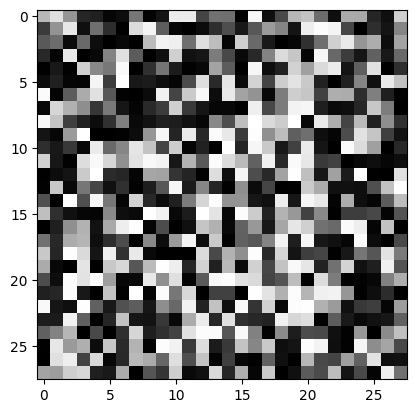

1/1 [==============================] - 0s 412ms/step


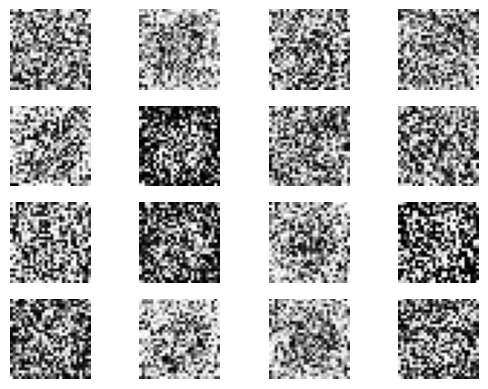

In [10]:
# For single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('generator_model.h5')

# To create same image, suppy same vector each time
# all 0s
# vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

# To create random images each time...
# Vector of random numbers (creates a column, need to reshape)
vector = randn(100)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

In [ ]:
from keras.datasets import mnist
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

def build_generator():

    noise_shape = (100,)  # 1D array of size 100 (latent vector / noise)

    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)  # Generated image

    return Model(noise, img)

def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)
        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective.
        d_loss_real = discriminator.train_on_batch(
            imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(
            gen_imgs, np.zeros((half_batch, 1)))
    # take average loss from real and fake images.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

# Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))

        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
              (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

optimizer = Adam(0.0002, 0.5)  # Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build and compile our Discriminator, pick the loss function

# SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# This builds the Generator and defines the input noise.
# In a GAN the Generator network takes noise z as an input to produce its images.
z = Input(shape=(100,))  # Our random input to the generator
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)  # Validity check on the generated image
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=30000, batch_size=32, save_interval=10)
generator.save('generator_model.h5')  # Test the model on GAN4_predict...
# Change epochs back to 30K

# Epochs dictate the number of backward and forward propagations, the batch_size
# indicates the number of training samples per backward/forward propagation, and the
# sample_interval specifies after how many epochs we call our sample_image function.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
6116 [D loss: 0.553063, acc.: 75.00%] [G loss: 0.920586]
1/1 [==============================] - 0s 26ms/step
6117 [D loss: 0.638080, acc.: 62.50%] [G loss: 0.956968]
1/1 [==============================] - 0s 26ms/step
6118 [D loss: 0.645685, acc.: 59.38%] [G loss: 0.830091]
1/1 [==============================] - 0s 26ms/step
6119 [D loss: 0.694401, acc.: 53.12%] [G loss: 0.790356]
1/1 [==============================] - 0s 25ms/step
6120 [D loss: 0.617424, acc.: 71.88%] [G loss: 0.898289]
1/1 [==============================] - 0s 25ms/step
6121 [D loss: 0.681809, acc.: 50.00%] [G loss: 0.837975]
1/1 [==============================] - 0s 27ms/step
6122 [D loss: 0.691704, acc.: 46.88%] [G loss: 0.847239]
1/1 [==============================] - 0s 26ms/step
6123 [D loss: 0.644910, acc.: 59.38%] [G loss: 0.895553]
1/1 [==============================] - 0s 25ms/step
6124 [D loss: 0.630292, a

In [ ]:
from google.colab import files
import os

dir_to_zip = 'images' #@param {type: "string"}
output_filename = 'file.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

In [1]:
!zip -r images.zip /content/images


  adding: content/images/ (stored 0%)
  adding: content/images/mnist_5310.png (deflated 8%)
  adding: content/images/mnist_2580.png (deflated 6%)
  adding: content/images/mnist_6660.png (deflated 8%)
  adding: content/images/mnist_3080.png (deflated 6%)
  adding: content/images/mnist_7110.png (deflated 8%)
  adding: content/images/mnist_3580.png (deflated 7%)
  adding: content/images/mnist_20.png (deflated 11%)
  adding: content/images/mnist_260.png (deflated 9%)
  adding: content/images/mnist_2490.png (deflated 6%)
  adding: content/images/mnist_7120.png (deflated 8%)
  adding: content/images/mnist_5760.png (deflated 7%)
  adding: content/images/mnist_2980.png (deflated 6%)
  adding: content/images/mnist_8210.png (deflated 7%)
  adding: content/images/mnist_990.png (deflated 6%)
  adding: content/images/mnist_740.png (deflated 6%)
  adding: content/images/mnist_1270.png (deflated 6%)
  adding: content/images/mnist_1050.png (deflated 6%)
  adding: content/images/mnist_7650.png (deflate

In [2]:
from google.colab import files
files.download('images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from PIL import Image

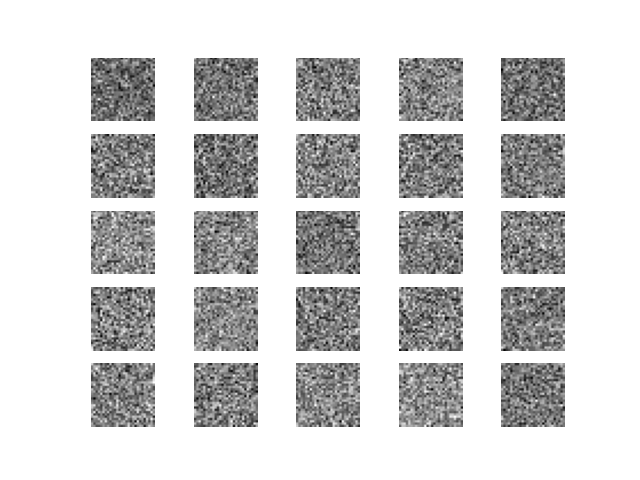

In [7]:
image_path = "/content/images/mnist_0.png"
image = Image.open(image_path)
image.show()

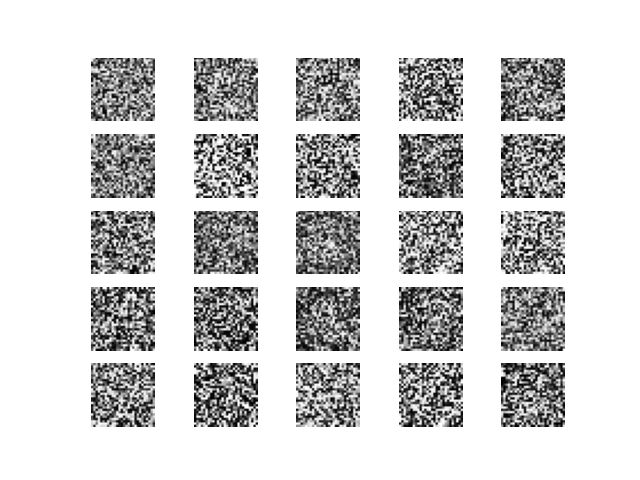

In [8]:
image_path = "/content/images/mnist_100.png"
image = Image.open(image_path)
image.show()

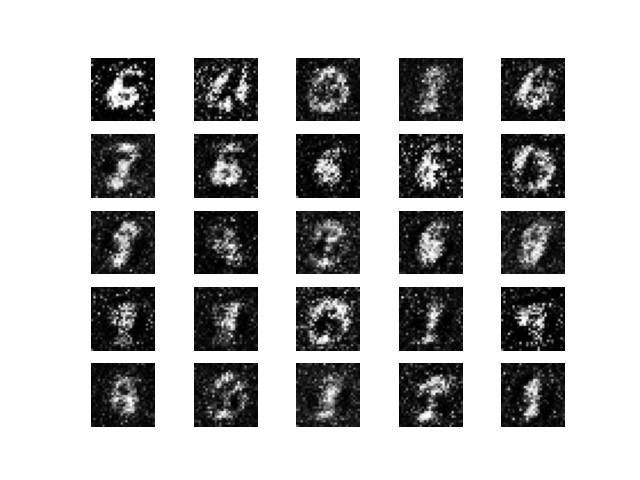

In [10]:
image_path = "/content/images/mnist_1000.png"
image = Image.open(image_path)
image.show()

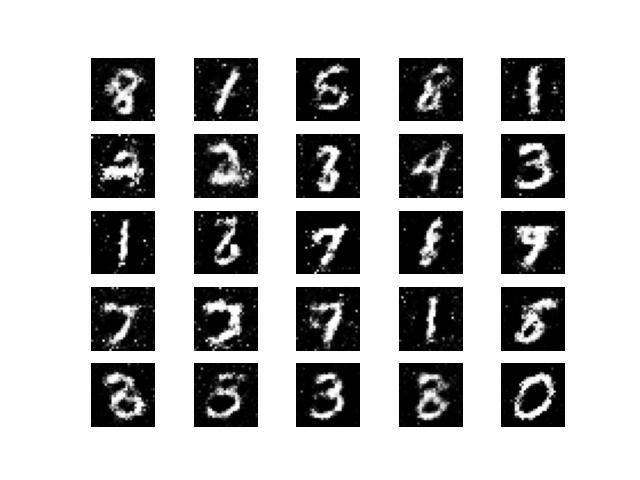

In [11]:
image_path = "/content/images/mnist_5000.png"
image = Image.open(image_path)
image.show()

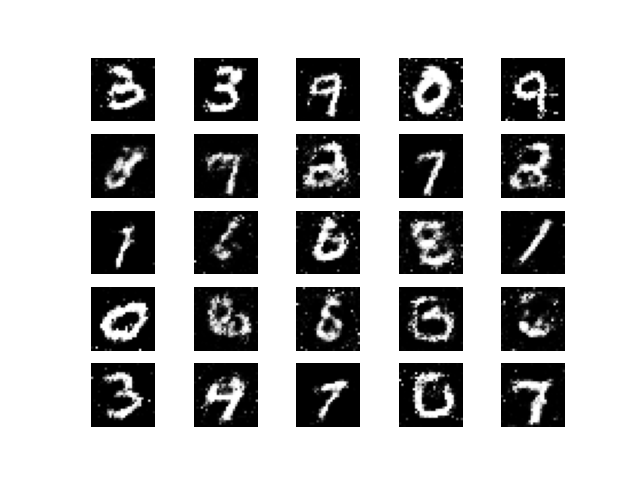

In [5]:
from PIL import Image

image_path = "/content/images/mnist_8490.png"
image = Image.open(image_path)
image.show()

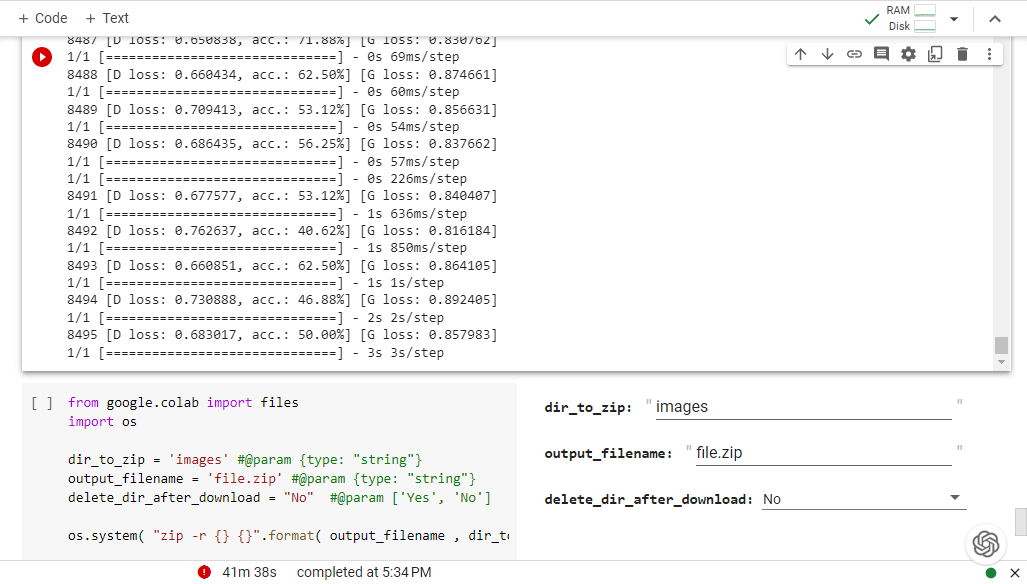

In [14]:
image_path = "/content/Screenshot 2023-05-02 173957.png"
image = Image.open(image_path)
image.show()